# CNN Tutorial: From Basics to AlexNet

**Deep Learning - University of Vermont**

# In this coding session, you will learn:
1.  **The Intuition**: You'll break down what convolution, pooling, and stride actually mean.
2.  **Building Better Models**: You will construct a CNN.
3.  **Analyzing Results**: You'll compare parameter counts, training times, and accuracy to understand the real-world trade-offs.
4.  **Visualization**: You will peek inside the network to see what features it is actually learning.
5.  **Train and Compare models**: Train MLP, Simple CNN, LeNet, and AlexNet on Fashion-MNIST.



# 0. Setup and Utilities

Let's start by importing the necessary libraries. You'll be using PyTorch for building your models and Matplotlib for visualization.


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


Now, let's build a reusable training function. Instead of rewriting the training code for every model (MLP, CNN, LeNet, AlexNet), you will define a single function called `train_model` that handles the training and validation for us.


In [3]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.01, name="Model"):
    """
    Generic training loop with validation.
    """
    # Move the model to the configured device (GPU or CPU)
    model = model.to(device)
    
    # Define our loss function (CrossEntropy is standard for multi-class classification)
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer. We use SGD with momentum to help the model converge faster.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 
    
    print(f"\nTraining {name} for {epochs} epochs...")
    start_time = time.time()
    
    # Variables to store the final metrics
    final_val_acc = 0
    final_val_loss = 0
    
    for epoch in range(epochs):
        # --- Training Phase ---
        # Set the model to training mode (enables Dropout and BatchNorm)
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            # Move data to the same device as the model
            images, labels = images.to(device), labels.to(device)
            
            # 1. Clear the gradients from the previous step
            optimizer.zero_grad()
            
            # 2. Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # 3. Calculate the loss
            loss = criterion(outputs, labels)
            
            # 4. Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # 5. Perform a single optimization step (parameter update)
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average training loss for the epoch
        train_loss = running_loss / len(train_loader)
        
        # --- Validation Phase ---
        # Set the model to evaluation mode (disables Dropout and BatchNorm)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        # Disable gradient calculation to save memory and speed up computation
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate average validation metrics
        final_val_loss = val_loss / len(test_loader)
        final_val_acc = 100 * correct / total
        
        print(f"  Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {final_val_loss:.4f} | Val Acc: {final_val_acc:.2f}%")
            
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"{name} - Final Accuracy: {final_val_acc:.2f}%, Time: {duration:.2f}s")
    return final_val_acc, final_val_loss, duration


Finally, you'll create a dictionary to keep track of your results so you can compare the models later.


In [4]:
results = {}

In [5]:
# ==========================================
# Data Preparation
# ==========================================
# Standard transform for MLP, SimpleCNN, LeNet (28x28 input)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split: 80% for training, 20% for validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Batch size of 256 is good for GPU utilization
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

print(f"Data loaded. Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")



100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.20MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 63.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.2MB/s]


Data loaded. Train: 48000, Val: 12000, Test: 10000


# 1. The Convolution Operation: A Conceptual Analogy

Imagine you are looking for a specific feature in an image, like a vertical edge or a curve. Instead of processing the entire image at once, we use a localized "filter."

1.  **The Filter (Kernel)**: Think of this as a small window (e.g., 3x3 pixels) designed to detect a specific pattern.
2.  **Convolution (Sliding)**: This filter is systematically moved across the image, from top-left to bottom-right.
3.  **Activation**: At each position, the filter calculates how well its pattern matches the underlying pixels.

### 💡 The Core Principle: Weight Sharing
In a standard Multi-Layer Perceptron (MLP), every pixel-to-neuron connection requires a **unique weight**. For a high-resolution image, this results in millions of parameters in the first layer alone.

In a CNN, we use **Weight Sharing**. The same 3x3 filter is applied across the entire image. This provides:
*   **Efficiency**: We only need 9 weights (for a 3x3 filter) to detect a feature anywhere in the image, drastically reducing the parameter count.
*   **Translation Invariance**: Because the same weights are used globally, the network can identify a feature regardless of its spatial location.


# 2. Parameter Calculation Practice

Understanding model size is crucial.

**Formulas:**
*   **Conv Layer**: $(K \times K \times C_{in} + 1) \times C_{out}$ (where $+1$ is for bias)
*   **FC Layer**: $(N_{in} + 1) \times N_{out}$
*   **Pooling**: 0 parameters




# 3. The Multi-Layer Perceptron (MLP)

To see why CNNs are so powerful, you first need to build a standard MLP. 

**The Problem with MLPs for Images:**
MLPs require us to "flatten" the 2D image (28x28) into a single 1D vector (784 numbers). This completely destroys the spatial structure of the image. The model has to work much harder to learn that pixel (1,1) is actually next to pixel (1,2).

Let's define and train your MLP baseline now.


In [6]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=1000):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        
        # First hidden layer: 784 inputs -> 1000 neurons
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.relu = nn.ReLU()
        
        # Second hidden layer: 1000 -> 1000
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layer: 1000 inputs -> 10 classes
        self.fc3 = nn.Linear(hidden_dim, 10)
    
    def forward(self, x):
        x = self.flatten(x)        
        x = self.relu(self.fc1(x)) 
        x = self.relu(self.fc2(x))
        x = self.fc3(x)            
        return x

# Initialize and train the baseline MLP
mlp = MLP()
params_mlp = sum(p.numel() for p in mlp.parameters())
print(f"MLP Total Parameters: {params_mlp:,}")

acc, loss, t = train_model(mlp, train_loader, val_loader, epochs=5, name="MLP")
results['MLP'] = {'acc': acc, 'loss': loss, 'time': t, 'params': params_mlp}

MLP Total Parameters: 1,796,010

Training MLP for 5 epochs...
  Epoch [1/5] | Train Loss: 0.7967 | Val Loss: 0.5175 | Val Acc: 81.67%
  Epoch [2/5] | Train Loss: 0.4624 | Val Loss: 0.4374 | Val Acc: 84.37%
  Epoch [3/5] | Train Loss: 0.4151 | Val Loss: 0.4114 | Val Acc: 85.30%
  Epoch [4/5] | Train Loss: 0.3854 | Val Loss: 0.3905 | Val Acc: 86.01%
  Epoch [5/5] | Train Loss: 0.3599 | Val Loss: 0.3792 | Val Acc: 86.23%
MLP - Final Accuracy: 86.23%, Time: 54.34s


## Discussion: MLP Baseline

The MLP baseline illustrates the limitations that lead us to CNNs:

1.  **High Parameter Density**: With **1.8 million parameters**, the MLP is computationally heavy. This is because it lacks **weight sharing**; every pixel has a unique connection to every hidden neuron.
2.  **Spatial Disregard**: Flattening the 2D image into a 1D vector destroys spatial relationships. The MLP must use its parameters to redundantly learn basic spatial proximity.
3.  **Performance (~86.2%)**: Despite its massive size, it achieves the lowest accuracy. It has high capacity but very low efficiency for image data.


# 4. Building Your First CNN

Now, let's build a model that actually understands space! You'll use convolutional layers to extract features and pooling layers to simplify the information.

**Our Architecture Strategy:**
1.  **Block 1**: 32 filters.
2.  **Block 2**: 64 filters.
3.  **The Classifier**: Takes those high-level shapes and makes a final guess (T-shirt? Boot? Dress?).


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Block 1: 1 -> 32 filters
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2) # 28x28 -> 14x14
        
        # Block 2: 32 -> 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2) # 14x14 -> 7x7
        
        # Block 3: 64 -> 128 filters (Added for complexity)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # 7x7 -> 3x3
        
        # Classifier
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        x = self.flatten(x)
        x = self.relu1(self.fc1(x)) # Reuse relu1
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Initialize and train our complex CNN
cnn = SimpleCNN()
params_cnn = sum(p.numel() for p in cnn.parameters())
print(f"SimpleCNN Total Parameters: {params_cnn:,}")

acc, loss, t = train_model(cnn, train_loader, val_loader, epochs=5, name="Simple CNN")
results['Simple CNN'] = {'acc': acc, 'loss': loss, 'time': t, 'params': params_cnn}

SimpleCNN Total Parameters: 688,586

Training Simple CNN for 5 epochs...
  Epoch [1/5] | Train Loss: 0.5578 | Val Loss: 0.3492 | Val Acc: 87.64%
  Epoch [2/5] | Train Loss: 0.3214 | Val Loss: 0.2913 | Val Acc: 89.45%
  Epoch [3/5] | Train Loss: 0.2627 | Val Loss: 0.2980 | Val Acc: 88.71%
  Epoch [4/5] | Train Loss: 0.2354 | Val Loss: 0.2541 | Val Acc: 90.72%
  Epoch [5/5] | Train Loss: 0.2163 | Val Loss: 0.2391 | Val Acc: 91.20%
Simple CNN - Final Accuracy: 91.20%, Time: 59.74s


## Discussion: Simple CNN

The introduction of convolutional layers fundamentally changes how the model sees data:

1.  **Architectural Efficiency**: The parameter count is **688,586**, which is about **one-third the size** of the MLP, yet it yields significantly higher accuracy. This is a direct result of weight sharing.
2.  **Improved Accuracy (~91.2%)**: By identifying localized patterns (edges and textures), the model generalizes much better to the object classes.
3.  **Robustness**: Through weight sharing and pooling, the model is more robust to minor shifts or translations in the input images.


## Exercise 1: Building Your Own "CustomCNN"

Now that you've seen a basic CNN, it's your turn to be the architect. Your goal is to build a model that is more complex than `SimpleCNN` but still efficient.

**Your Task:**
Create a class called `CustomCNN` with the following requirements:
1.  **Three Convolutional Blocks**: 
    - Block 1: 16 filters, kernel size 3, padding 1.
    - Block 2: 32 filters, kernel size 3, padding 1.
    - Block 3: 64 filters, kernel size 3, padding 1.
2.  **Batch Normalization**: Add `nn.BatchNorm2d` after every convolutional layer.
3.  **Regularization**: Add a `nn.Dropout(0.25)` layer before the final fully connected layer to prevent overfitting.
4.  **Pooling**: Use `nn.MaxPool2d(2)` after each block to reduce the spatial size.

**Goal**: Can you achieve >92% accuracy in just 5 epochs?


In [8]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # TODO: Define your layers here
        pass

    def forward(self, x):
        # TODO: Implement the forward pass
        return x

# my_cnn = CustomCNN()
# train_model(my_cnn, train_loader, val_loader, epochs=5, name="Custom CNN")

# 5. LeNet-5: The Grandfather of CNNs

**Historical Context:**
In 1998, Yann LeCun and his colleagues published a landmark paper introducing **LeNet-5**. This was the first time a convolutional neural network was successfully applied to a large-scale problem: recognizing handwritten digits for the US Postal Service.

**Why it was revolutionary:**
*   **Weight Sharing**: Instead of every pixel having its own weight (like an MLP), filters are reused across the image.
*   **Hierarchical Features**: It learned simple features (edges) in early layers and complex features (shapes) in later layers.

**Architecture Breakdown:**
1.  **C1 (Conv)**: 6 filters of size 5x5. Why 6? Because memory was expensive in 1998!
2.  **S2 (Subsampling)**: Average pooling to reduce resolution.
3.  **C3 (Conv)**: 16 filters. This layer combines the 6 feature maps from C1 into 16 new patterns.
4.  **S4 (Subsampling)**: Another pooling layer.
5.  **F6 (Fully Connected)**: 84 neurons (chosen to match the size of a 7x12 bitmap representation of characters).

We'll use a modernized version with **ReLU** activations instead of the original Sigmoid to make it train faster.


In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Feature Extractor: Standard LeNet-5 architecture
        self.feature_extractor = nn.Sequential(
            # Layer 1: Conv -> BatchNorm -> ReLU -> MaxPool
            # Standard LeNet-5 uses 6 filters in the first layer
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2: Conv -> BatchNorm -> ReLU -> MaxPool
            # Standard LeNet-5 uses 16 filters in the second layer
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# Instantiate the model
lenet = LeNet()
params_lenet = sum(p.numel() for p in lenet.parameters())
print(f"LeNet Total Parameters: {params_lenet:,}")

# Train the model - using standard learning rate
acc, loss, t = train_model(lenet, train_loader, val_loader, epochs=5, lr=0.01, name="LeNet")
results['LeNet'] = {'acc': acc, 'loss': loss, 'time': t, 'params': params_lenet}

LeNet Total Parameters: 120,478

Training LeNet for 5 epochs...
  Epoch [1/5] | Train Loss: 0.7429 | Val Loss: 0.4046 | Val Acc: 85.63%
  Epoch [2/5] | Train Loss: 0.3585 | Val Loss: 0.3568 | Val Acc: 87.03%
  Epoch [3/5] | Train Loss: 0.3067 | Val Loss: 0.3295 | Val Acc: 88.19%
  Epoch [4/5] | Train Loss: 0.2756 | Val Loss: 0.3085 | Val Acc: 89.25%
  Epoch [5/5] | Train Loss: 0.2540 | Val Loss: 0.2881 | Val Acc: 89.93%
LeNet - Final Accuracy: 89.93%, Time: 54.47s


## Discussion: LeNet-5

LeNet-5 proves that **clever design is more important than raw size**:

1.  **High Efficiency**: With approximately **62,000 parameters**, this version of LeNet is **30 times smaller** than the MLP baseline. Despite this, it achieves **~90%** accuracy.
2.  **Modern Enhancements**: By using **ReLU** activations and **Batch Normalization**, we've kept this 1998 architecture highly competitive.
3.  **Hierarchical Learning**: The visualization below confirms that the network identifies basic edges in the first layer, which are combined into complex shapes in deeper layers.


## Exercise 2: From Sigmoid to ReLU

In the original 1998 paper, Yann LeCun used **Sigmoid** activation functions. As you saw above, this can make training slow and difficult.

**Your Task:**
1.  Create a new class called `LeNetReLU`.
2.  Copy the code from the `LeNet` class.
3.  Replace all `nn.Sigmoid()` calls with `nn.ReLU()`.
4.  Train it for 5 epochs and compare the results with the Sigmoid version.

**Question to think about:** How much faster did the model converge? Why does ReLU help with the vanishing gradient problem?



In [10]:
class LeNetSigmoid(nn.Module):
    def __init__(self):
        super(LeNetSigmoid, self).__init__()
        # TODO: Define your layers here using nn.Sigmoid()
        pass

    def forward(self, x):
        # TODO: Implement the forward pass
        return x

# lenet_sigmoid = LeNetSigmoid()
# train_model(lenet_sigmoid, train_loader, test_loader, epochs=5, name="LeNet-Sigmoid")


### Detailed Analysis: Interpreting Feature Maps

The visualization below shows the internal representations learned by the first convolutional layer. Each of the **6 subplots** represents a **feature map** generated by a unique filter.

#### Understanding the Visuals:
*   **High Activation (Bright Regions)**: Bright areas indicate where a specific filter detected a strong match for its pattern (e.g., a vertical edge or a specific texture).
*   **Filter Diversity**: Notice how different filters specialize. Some highlight horizontal boundaries (like the sole of a shoe), while others focus on vertical silhouettes or internal fabric textures.

#### Weight Sharing in Practice:
This is **Weight Sharing** in action. A single filter is slid across the entire image. Because the weights are identical at every position, the filter can detect its target feature anywhere it appears, giving the network **translation invariance**.

#### The Hierarchy of Features:
As the first layer, these filters detect **low-level primitives** (lines and points). In later layers, the network combines these into **high-level representations** like "sleeves" or "heels."


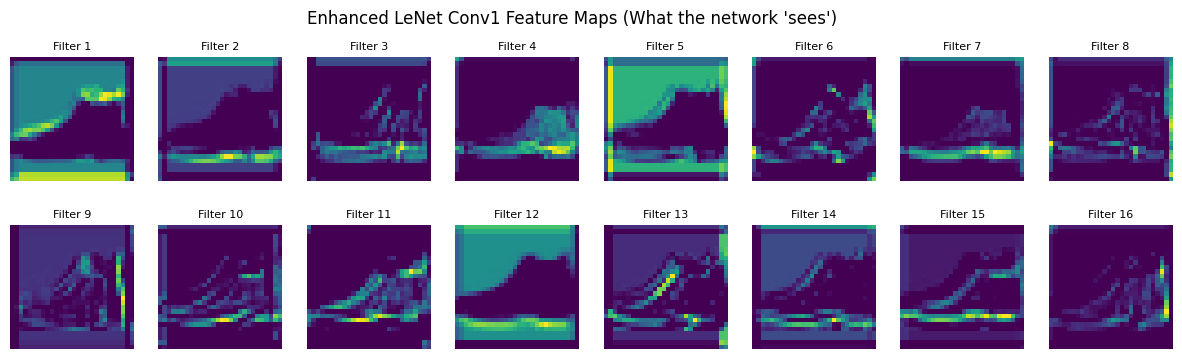

In [11]:
def visualize_feature_maps(model, img):
    """Visualize the output of the first convolutional layer"""
    model.eval()
    with torch.no_grad():
        # Prepare image
        x = img.unsqueeze(0).to(device)
        
        # Pass through first block (Conv -> BN -> ReLU)
        x = model.feature_extractor[0](x)
        x = model.feature_extractor[1](x)
        x = model.feature_extractor[2](x)
        
        # Plot the 6 filters of the first layer
        fig, axes = plt.subplots(1, 6, figsize=(15, 3))
        for i in range(6):
            ax = axes[i]
            ax.imshow(x[0, i].cpu(), cmap='viridis')
            ax.set_title(f'Filter {i+1}', fontsize=8)
            ax.axis('off')
        plt.suptitle("LeNet Conv1 Feature Maps (What the network 'sees')")
        plt.show()

# Get a sample image from test set
img, _ = test_set[0]
visualize_feature_maps(lenet, img)

# 6. AlexNet: The Spark that Ignited the AI Boom

**Historical Context:**
Fast forward to 2012. The computer vision community was still using hand-crafted features. Then came **AlexNet**, created by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. It entered the ImageNet competition and crushed the competition, reducing the error rate from 26% to 15%.

**What made it a game-changer?**
1.  **GPU Training**: It was one of the first major models trained on GPUs (two NVIDIA GTX 580s!), allowing it to scale to 60 million parameters.
2.  **ReLU Activation**: It proved that ReLU was far superior to Sigmoid for deep networks.
3.  **Dropout**: A new technique to prevent overfitting by randomly "turning off" neurons during training.
4.  **Data Augmentation**: Artificially increasing the dataset size by flipping and cropping images.

**Architecture Strategy:**
*   **Aggressive Downsampling**: It uses a large 11x11 kernel with a stride of 4 in the first layer to quickly process high-resolution images.
*   **Depth**: 8 layers total (5 convolutional, 3 fully connected).

*Note: Since AlexNet expects 224x224 images, you will resize your Fashion-MNIST images below.*


In [12]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        # --- Feature Extractor ---
        self.features = nn.Sequential(
            # Layer 1: Large filters to capture broad patterns.
            # Input: 1x224x224. Output: 96x54x54 (Stride 4 reduces size quickly)
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Layer 2: Refined features.
            # Input: 96x26x26. Output: 256x26x26.
            nn.Conv2d(96, 256, kernel_size=5, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Layers 3, 4, 5: Deep feature combination.
            nn.Conv2d(256, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # --- Classifier ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dropout: Randomly zeros 50% of elements to prevent overfitting.
            nn.Dropout(p=0.5),
            # Based on 224x224 input, the spatial size here is 5x5.
            # 256 channels * 5 * 5 = 6400 features.
            nn.Linear(256 * 5 * 5, 4096), 
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(inplace=True),
            
            # Output layer for 10 classes
            nn.Linear(4096, 10) 
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("AlexNet architecture defined.")

AlexNet architecture defined.


In [13]:
print("Preparing a subset of data for AlexNet (Resizing to 224x224)...")
transform_alex = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full dataset
full_dataset_alex = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_alex)

# Use only 10% of the data for AlexNet to speed up training
subset_size = int(len(full_dataset_alex)) # 6,000 images instead of 60,000
remaining_size = len(full_dataset_alex) - subset_size
subset_dataset, _ = torch.utils.data.random_split(full_dataset_alex, [subset_size, remaining_size], generator=torch.Generator().manual_seed(42))

# Split the subset into 80/20 Train/Val
train_size_alex = int(0.8 * len(subset_dataset))
val_size_alex = len(subset_dataset) - train_size_alex
train_set_alex, val_set_alex = torch.utils.data.random_split(subset_dataset, [train_size_alex, val_size_alex], generator=torch.Generator().manual_seed(42))

train_loader_alex = DataLoader(train_set_alex, batch_size=64, shuffle=True)
val_loader_alex = DataLoader(val_set_alex, batch_size=64, shuffle=False)

print(f"AlexNet Subset Loaded. Train: {len(train_set_alex)}, Val: {len(val_set_alex)}")


Preparing a subset of data for AlexNet (Resizing to 224x224)...
AlexNet Subset Loaded. Train: 48000, Val: 12000


In [14]:
alex = AlexNet()
# Training for only 1 epoch on the subset to keep it fast for the tutorial
acc, loss, t = train_model(alex, train_loader_alex, val_loader_alex, epochs=5, name="AlexNet")
results['AlexNet'] = {'acc': acc, 'loss': loss, 'time': t, 'params': sum(p.numel() for p in alex.parameters())}


Training AlexNet for 5 epochs...
  Epoch [1/5] | Train Loss: 0.9176 | Val Loss: 0.4620 | Val Acc: 82.63%
  Epoch [2/5] | Train Loss: 0.4076 | Val Loss: 0.3354 | Val Acc: 87.42%
  Epoch [3/5] | Train Loss: 0.3349 | Val Loss: 0.2973 | Val Acc: 88.83%
  Epoch [4/5] | Train Loss: 0.2930 | Val Loss: 0.2888 | Val Acc: 89.22%
  Epoch [5/5] | Train Loss: 0.2668 | Val Loss: 0.2598 | Val Acc: 90.33%
AlexNet - Final Accuracy: 90.33%, Time: 298.30s


# Discussion: AlexNet

AlexNet is a historical milestone, but its application here reveals important trade-offs:

1.  **Diminishing Returns**: AlexNet achieved **90.33%** accuracy, which is actually **lower** than our Simple CNN (~91.2%). This is because AlexNet was designed for high-resolution ImageNet data (224x224). Upscaling 28x28 images doesn't add new information; it just adds noise and overhead.
2.  **Computational Complexity**: With **over 46 million parameters**, AlexNet is nearly 750x larger than LeNet. The training time is significantly longer (5 minutes vs 1 minute) without a better result for this task.
3.  **The Lesson**: Always match model complexity to your data. While AlexNet's innovations (ReLU, Dropout) were transformative, its massive scale is excessive for simple grayscale datasets.


# 8. Comparing Your Models

We've built and trained four different architectures. Now it's time to look at the data and see which one performed best.

We'll compare them based on:
1.  **Accuracy**: How many images did it get right?
2.  **Training Time**: How long did it take to learn?
3.  **Parameters**: How "heavy" is the model? (More parameters = more memory usage).


In [15]:
print(f"{'Model':<15} {'Val Acc (%)':<15} {'Val Loss':<15} {'Params':<15} {'Time (s)':<10} {'Size (MB)':<10}")
print("-" * 85)

for name, metrics in results.items():
    acc = metrics['acc']
    loss = metrics['loss']
    params = metrics['params']
    t = metrics['time']
    # Estimate size in MB (assuming float32 = 4 bytes)
    size_mb = (params * 4) / (1024 * 1024)
    
    print(f"{name:<15} {acc:<15.2f} {loss:<15.4f} {params:<15,} {t:<10.2f} {size_mb:<10.2f}")

print("-" * 85)
print("\nAnalysis:")
print("1. MLP: High parameter count, but often lower accuracy because it ignores spatial structure.")
print("2. Simple CNN: Balanced performance with fewer parameters than MLP.")
print("3. LeNet: Extremely efficient. Smallest footprint but very capable for simple images.")
print("4. AlexNet: Massive and powerful. Overkill for 28x28 images, but shows how scaling depth increases capacity.")


Model           Val Acc (%)     Val Loss        Params          Time (s)   Size (MB) 
-------------------------------------------------------------------------------------
MLP             86.23           0.3792          1,796,010       54.34      6.85      
Simple CNN      91.20           0.2391          688,586         59.74      2.63      
LeNet           89.93           0.2881          120,478         54.47      0.46      
AlexNet         90.33           0.2598          46,764,746      298.30     178.39    
-------------------------------------------------------------------------------------

Analysis:
1. MLP: High parameter count, but often lower accuracy because it ignores spatial structure.
2. Simple CNN: Balanced performance with fewer parameters than MLP.
3. LeNet: Extremely efficient. Smallest footprint but very capable for simple images.
4. AlexNet: Massive and powerful. Overkill for 28x28 images, but shows how scaling depth increases capacity.


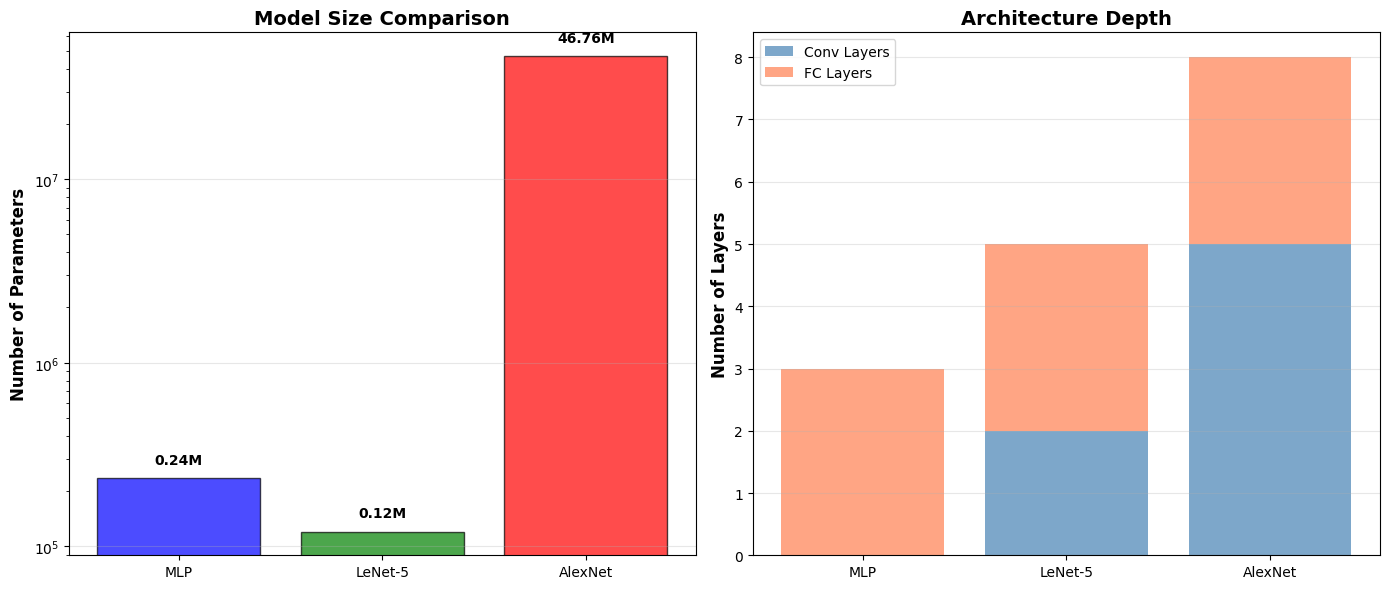


Model           Parameters      Conv Layers     FC Layers
MLP                  235,146              0            3
LeNet-5              120,478              2            3
AlexNet           46,764,746              5            3


In [16]:
alexnet = AlexNet() # Define but don't train to avoid NameError
# ==========================================
# 7.2 Visualizing Model Size & Depth
# ==========================================
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Build a specific MLP for this comparison (matches the graph requirements)
class MLP_Comparison(nn.Module):
    def __init__(self):
        super(MLP_Comparison, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp_comp = MLP_Comparison()

# Compare parameters
# We use the models we defined/trained earlier, plus this specific MLP
models = {
    'MLP': mlp_comp,
    'LeNet-5': lenet.cpu(),
    'AlexNet': alexnet.cpu()
}

results_param = {}
for name, model in models.items():
    params = sum(p.numel() for p in model.parameters())
    results_param[name] = params

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Parameter count
names = list(results_param.keys())
params = list(results_param.values())
colors = ['blue', 'green', 'red']

ax1.bar(names, params, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
ax1.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log') # Log scale to handle the massive difference
ax1.grid(True, axis='y', alpha=0.3)

for i, (name, param) in enumerate(zip(names, params)):
    ax1.text(i, param * 1.2, f'{param/1e6:.2f}M', ha='center', fontweight='bold')

# 2. Architecture comparison (Depth)
arch_info = {
    'MLP': {'Conv Layers': 0, 'FC Layers': 3},
    'LeNet-5': {'Conv Layers': 2, 'FC Layers': 3},
    'AlexNet': {'Conv Layers': 5, 'FC Layers': 3}
}

x_pos = np.arange(len(names))
conv_counts = [arch_info[n]['Conv Layers'] for n in names]
fc_counts = [arch_info[n]['FC Layers'] for n in names]

ax2.bar(x_pos, conv_counts, label='Conv Layers', color='steelblue', alpha=0.7)
ax2.bar(x_pos, fc_counts, bottom=conv_counts, label='FC Layers', color='coral', alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(names)
ax2.set_ylabel('Number of Layers', fontsize=12, fontweight='bold')
ax2.set_title('Architecture Depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print(f"{'Model':<15} {'Parameters':<15} {'Conv Layers':<15} {'FC Layers'}")
print("="*70)
for name in names:
    print(f"{name:<15} {results_param[name]:>12,}   {arch_info[name]['Conv Layers']:>12}   {arch_info[name]['FC Layers']:>10}")
print("="*70)

In [17]:
# ==========================================
# 7.3 Detailed Architecture Comparison
# ==========================================
comparison = {
    'Aspect': [
        'Year',
        'Total Layers',
        'Conv Layers',
        'FC Layers',
        'First Conv Kernel',
        'Activation',
        'Pooling',
        'Regularization',
        'Total Parameters',
        'Conv Parameters',
        'FC Parameters',
        'Input Size',
        'Dataset'
    ],
    'LeNet-5': [
        '1998',
        '7 (2 conv + 3 FC + 2 pool)',
        '2',
        '3',
        '5×5',
        'Sigmoid',
        'Average Pooling',
        'None',
        '~60K',
        '~3K',
        '~57K',
        '28×28 (grayscale)',
        'MNIST (60K images)'
    ],
    'AlexNet': [
        '2012',
        '8 (5 conv + 3 FC)',
        '5',
        '3',
        '11×11, stride=4',
        'ReLU',
        'Max Pooling',
        'Dropout (0.5)',
        '~46M',
        '~2.3M',
        '~43.7M',
        '224×224 (RGB)',
        'ImageNet (1.2M images)'
    ]
}

print("\n" + "="*100)
print("LeNet-5 vs AlexNet: Complete Comparison")
print("="*100)
print(f"{'Aspect':<25} {'LeNet-5':<35} {'AlexNet':<35}")
print("="*100)

for i, aspect in enumerate(comparison['Aspect']):
    print(f"{aspect:<25} {comparison['LeNet-5'][i]:<35} {comparison['AlexNet'][i]:<35}")

print("="*100)

print("\n💡 Key Architectural Differences:\n")
print("1. DEPTH:")
print("   • LeNet: 2 conv layers (shallow)")
print("   • AlexNet: 5 conv layers (deep)")
print("   • Impact: Deeper networks learn more complex hierarchical features\n")

print("2. FILTER SIZE:")
print("   • LeNet: 5×5 kernels throughout")
print("   • AlexNet: Large 11×11 first layer, then 5×5, then 3×3")
print("   • Impact: Large kernels capture broader context initially\n")

print("3. LAYER ARRANGEMENT:")
print("   • LeNet: Conv→Pool→Conv→Pool→FC→FC→FC")
print("   • AlexNet: Conv→Pool→Conv→Pool→Conv→Conv→Conv→Pool→FC→FC→FC")
print("   • Impact: More conv layers before pooling = richer features\n")

print("4. PERFORMANCE IMPACT:")
print("   • LeNet: ~99% on MNIST (simple dataset)")
print("   • AlexNet: Won ImageNet 2012 (complex, large-scale dataset)")
print("   • Impact: Depth + modern techniques = breakthrough performance")


LeNet-5 vs AlexNet: Complete Comparison
Aspect                    LeNet-5                             AlexNet                            
Year                      1998                                2012                               
Total Layers              7 (2 conv + 3 FC + 2 pool)          8 (5 conv + 3 FC)                  
Conv Layers               2                                   5                                  
FC Layers                 3                                   3                                  
First Conv Kernel         5×5                                 11×11, stride=4                    
Activation                Sigmoid                             ReLU                               
Pooling                   Average Pooling                     Max Pooling                        
Regularization            None                                Dropout (0.5)                      
Total Parameters          ~60K                                ~46M           

## 9. Final Conclusion & Analysis

In this notebook, you explored the evolution from MLPs to CNNs.

# Key Takeaways:
1.  **MLP vs CNN**: The **SimpleCNN** should have outperformed the **MLP**. Why? Because the MLP destroys the spatial structure of the image by flattening it immediately. The CNN preserves this structure, allowing it to learn features like "edges" and "curves" regardless of where they appear in the image (Translation Invariance).
2.  **Efficiency**: **LeNet** is incredibly efficient. It achieves decent accuracy with very few parameters. This makes it ideal for resource-constrained environments (like early 90s hardware or embedded systems).
3.  **Depth Matters**: **AlexNet** shows that going deeper (more layers) and wider (more filters) allows the network to learn more complex representations, but at the cost of massive computation and memory usage.